In [1]:
from tqdm import tqdm
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# For Google Colab - Download and setup dataset
import kagglehub
import shutil
import os

# Download latest version of the Intel Image Classification dataset
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)

# Create data directory structure expected by the rest of the notebook
if os.path.exists('./data'):
    shutil.rmtree('./data')

# Copy the downloaded dataset to 'data' folder
shutil.copytree(path, './data')

print("Dataset organized in './data' folder for compatibility with existing code")
print("Available directories:", os.listdir('./data'))

# Verify the structure
expected_dirs = ['seg_train', 'seg_test', 'seg_pred']
for dir_name in expected_dirs:
    if os.path.exists(f'./data/{dir_name}'):
        print(f"✓ {dir_name}/ directory found")
        classes = os.listdir(f'./data/{dir_name}')
        print(f"  Classes: {classes}")
    else:
        print(f"✗ {dir_name}/ directory not found")

print("\nDataset ready for training!")

100%|██████████| 346M/346M [00:02<00:00, 137MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2
Dataset organized in './data' folder for compatibility with existing code
Available directories: ['seg_test', 'seg_pred', 'seg_train']
✓ seg_train/ directory found
  Classes: ['seg_train']
✓ seg_test/ directory found
  Classes: ['seg_test']
✓ seg_pred/ directory found
  Classes: ['seg_pred']

Dataset ready for training!


In [3]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [4]:
def load_data():
    datasets = ['./data/seg_train', './data/seg_test']
    output = []

    # Iterate through training and test sets
    for dataset_base_path in datasets:

        # Construct the path to the directory containing actual class folders
        # For './data/seg_train', this becomes './data/seg_train/seg_train'
        # For './data/seg_test', this becomes './data/seg_test/seg_test'
        actual_classes_path = os.path.join(dataset_base_path, os.path.basename(dataset_base_path))

        images = []
        labels = []

        print("Loading {}".format(actual_classes_path))

        # Iterate through each folder corresponding to a category (e.g., 'mountain', 'street')
        for class_folder_name in os.listdir(actual_classes_path):
            # Ensure we only process actual class folders and not any hidden files or other unexpected directories
            if class_folder_name not in class_names_label:
                print(f"Warning: '{class_folder_name}' found in '{actual_classes_path}' is not a recognized class name. Skipping.")
                continue

            label = class_names_label[class_folder_name]

            # Iterate through each image in our class folder
            for file in tqdm(os.listdir(os.path.join(actual_classes_path, class_folder_name))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(actual_classes_path, class_folder_name), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')

        output.append((images, labels))

    return output

In [5]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading ./data/seg_train/seg_train


100%|██████████| 2404/2404 [00:00<00:00, 3049.70it/s]


Loading ./data/seg_test/seg_test


100%|██████████| 553/553 [00:00<00:00, 2187.04it/s]


In [6]:
train_images, train_labels = shuffle(
    train_images, train_labels, random_state=25)

In [7]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of testing examples: {}".format(n_test))
print("Each image is of size: {}".format(IMAGE_SIZE))

# Calculate class distribution for the pie chart
train_counts = []
for i in range(nb_classes):
    train_counts.append(np.sum(train_labels == i))

print("\nClass distribution in training set:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {train_counts[i]} images")

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)

Class distribution in training set:
mountain: 2512 images
street: 2382 images
glacier: 2404 images
buildings: 2191 images
sea: 2274 images
forest: 2271 images


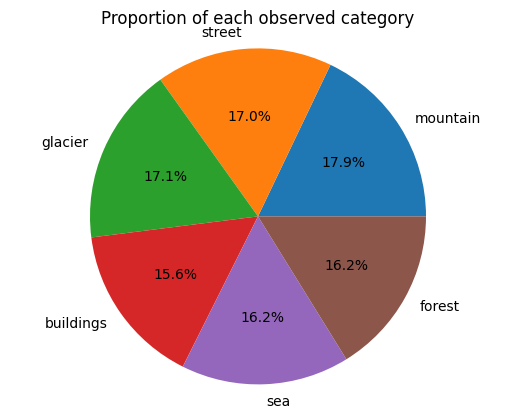

In [8]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0),
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [9]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [10]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

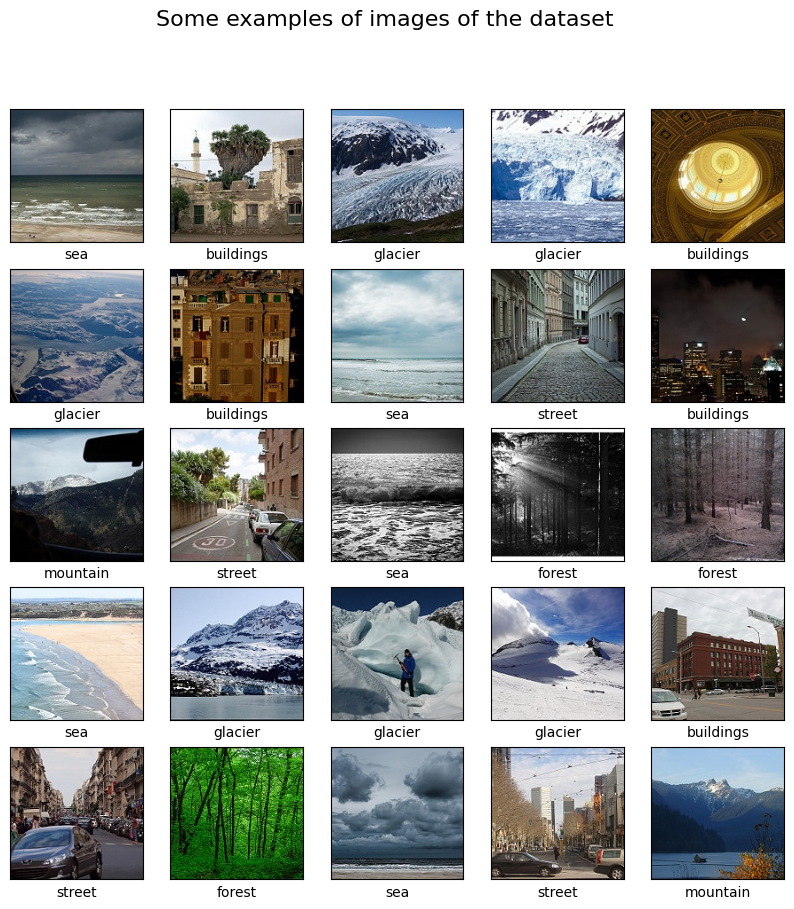

In [11]:
display_examples(class_names, train_images, train_labels)

In [12]:
model = tf.keras.Sequential([
    # Convolutional Block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # Convolutional Block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # Convolutional Block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # Dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Add model checkpoint callback to save best model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'models/best_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

# Train the model
history = model.fit(train_images, train_labels,
                    batch_size=128, epochs=20, validation_split=0.2,
                    callbacks=[checkpoint_callback])

print("Training completed!")
print("Best model saved at 'models/best_cnn_model.h5'")

# Save the final model as well
model.save('models/final_cnn_model.h5')
print("Final model saved at 'models/final_cnn_model.h5'")

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5836 - loss: 1.3516
Epoch 1: val_accuracy improved from -inf to 0.15924, saving model to models/best_cnn_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 287ms/step - accuracy: 0.5845 - loss: 1.3476 - val_accuracy: 0.1592 - val_loss: 4.0918
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7899 - loss: 0.6075
Epoch 2: val_accuracy did not improve from 0.15924
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.7898 - loss: 0.6078 - val_accuracy: 0.1592 - val_loss: 6.5199
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8037 - loss: 0.5572
Epoch 3: val_accuracy improved from 0.15924 to 0.17278, saving model to models/best_cnn_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.8038 - loss: 0.5569 - val_accuracy: 0.1728 - val_loss: 5.6450
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8439 - loss: 0.4308
Epoch 4: val_accuracy improved from 0.17278 to 0.37157, saving model to models/best_cnn_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.8439 - loss: 0.4309 - val_accuracy: 0.3716 - val_loss: 2.9440
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8627 - loss: 0.3775
Epoch 5: val_accuracy improved from 0.37157 to 0.46705, saving model to models/best_cnn_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.8628 - loss: 0.3774 - val_accuracy: 0.4670 - val_loss: 2.4805
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8902 - loss: 0.2997
Epoch 6: val_accuracy improved from 0.46705 to 0.60527, saving model to models/best_cnn_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.8902 - loss: 0.2997 - val_accuracy: 0.6053 - val_loss: 1.7796
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9025 - loss: 0.2718
Epoch 7: val_accuracy did not improve from 0.60527
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.9025 - loss: 0.2717 - val_accuracy: 0.5611 - val_loss: 2.3291
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9290 - loss: 0.2076
Epoch 8: val_accuracy improved from 0.60527 to 0.82829, saving model to models/best_cnn_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.9289 - loss: 0.2078 - val_accuracy: 0.8283 - val_loss: 0.5653
Epoch 9/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9441 - loss: 0.1691
Epoch 9: val_accuracy did not improve from 0.82829
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.9441 - loss: 0.1691 - val_accuracy: 0.7627 - val_loss: 0.8928
Epoch 10/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9521 - loss: 0.1405
Epoch 10: val_accuracy did not improve from 0.82829
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.9521 - loss: 0.1406 - val_accuracy: 0.7100 - val_loss: 1.1885
Epoch 11/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9507 - loss: 0.1418
Epoch 11: val_accuracy improved from 0.82829 to 0.83719, saving model to models/best_cnn_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.9507 - loss: 0.1417 - val_accuracy: 0.8372 - val_loss: 0.6459
Epoch 12/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9631 - loss: 0.1122
Epoch 12: val_accuracy did not improve from 0.83719
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.9631 - loss: 0.1122 - val_accuracy: 0.7720 - val_loss: 0.9198
Epoch 13/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9665 - loss: 0.0958
Epoch 13: val_accuracy did not improve from 0.83719
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.9665 - loss: 0.0959 - val_accuracy: 0.6758 - val_loss: 2.4799
Epoch 14/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9756 - loss: 0.0798
Epoch 14: val_accuracy did not improve from 0.83719
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.9756 - loss: 0.0799 - val_accuracy: 0.6081 - val_loss: 2.8111
Epoch 15/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9696 - loss: 0.0892
Epoch 15: val_accuracy d

88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9768 - loss: 0.0730 - val_accuracy: 0.8561 - val_loss: 0.6120
Epoch 17/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9813 - loss: 0.0597
Epoch 17: val_accuracy did not improve from 0.85607
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.9813 - loss: 0.0598 - val_accuracy: 0.7919 - val_loss: 0.9261
Epoch 18/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9777 - loss: 0.0615
Epoch 18: val_accuracy did not improve from 0.85607
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.9777 - loss: 0.0615 - val_accuracy: 0.8261 - val_loss: 0.7520
Epoch 19/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9848 - loss: 0.0476
Epoch 19: val_accuracy did not improve from 0.85607
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.9848 - loss: 0.0477 - val_accuracy: 0.7171 - val_loss: 1.4994
Epoch 20/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9808 - loss: 0.0580
Epoch 20: val_accuracy d

Training completed!
Best model saved at 'models/best_cnn_model.h5'
Final model saved at 'models/final_cnn_model.h5'


In [46]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10, 5))

    # Check which accuracy key is available (newer vs older TensorFlow versions)
    acc_key = 'accuracy' if 'accuracy' in history.history else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history[acc_key], 'o--', label=acc_key)
    plt.plot(history.history[val_acc_key], 'o--', label=val_acc_key)
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'o--', label="loss")
    plt.plot(history.history['val_loss'], 'o--', label="val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

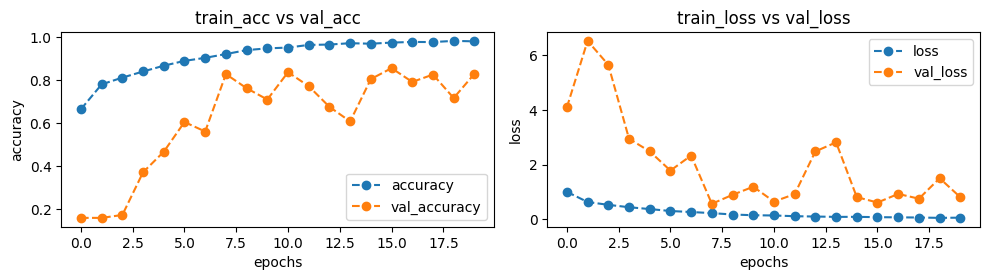

In [47]:
plot_accuracy_loss(history)

In [17]:
test_loss = model.evaluate(test_images, test_labels)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8080 - loss: 0.9040


In [18]:
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


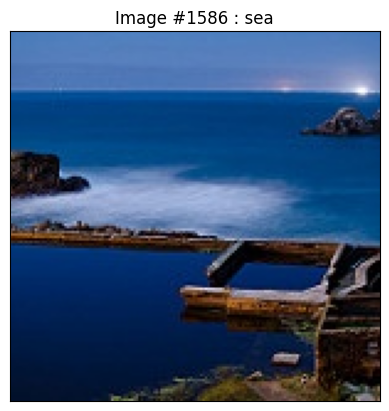

In [19]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis=1)  # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [20]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    mislabeled = (test_labels == pred_labels)
    mislabeled_indices = np.where(mislabeled == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

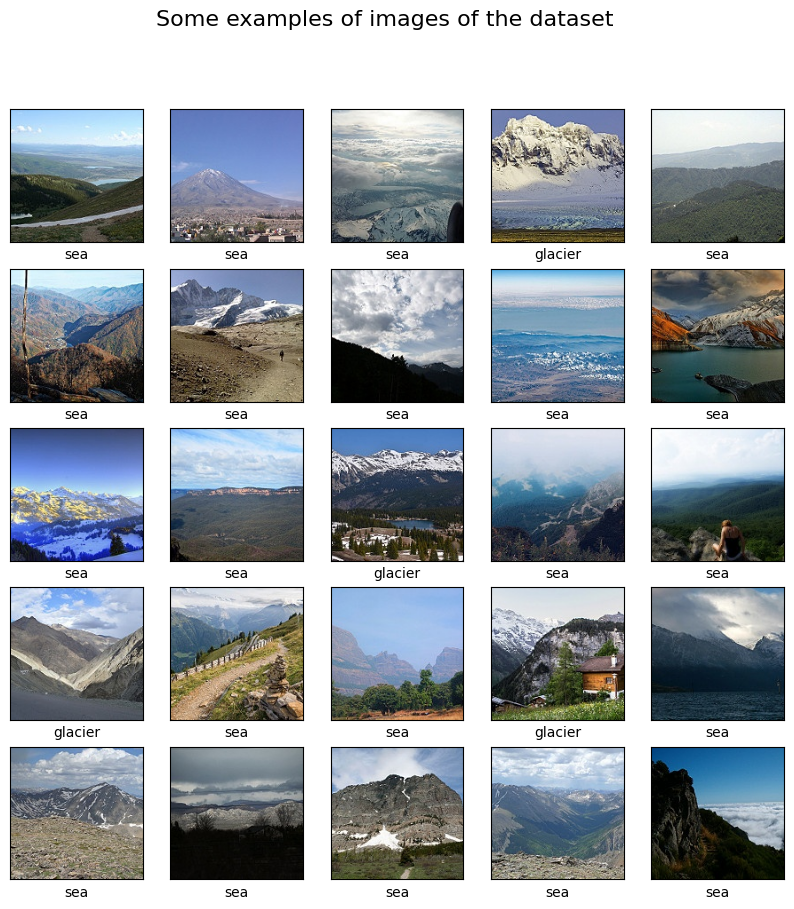

In [ ]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

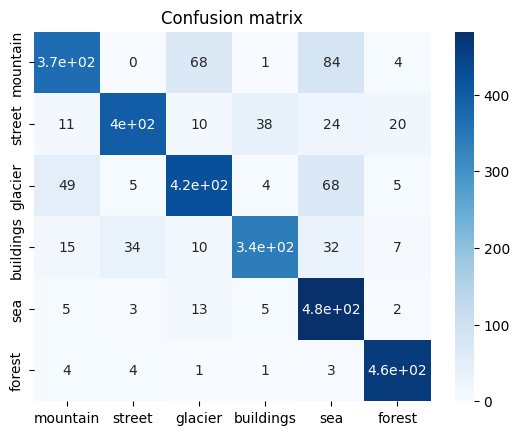

In [24]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sns.heatmap(CM, annot=True, cmap='Blues',
           xticklabels=class_names,
           yticklabels=class_names, ax=ax)
ax.set_title('Confusion matrix')
plt.show()

Data augmentation configured with:
- Rotation: ±20 degrees
- Width/Height shift: ±10%
- Horizontal flip: Yes
- Zoom: ±10%


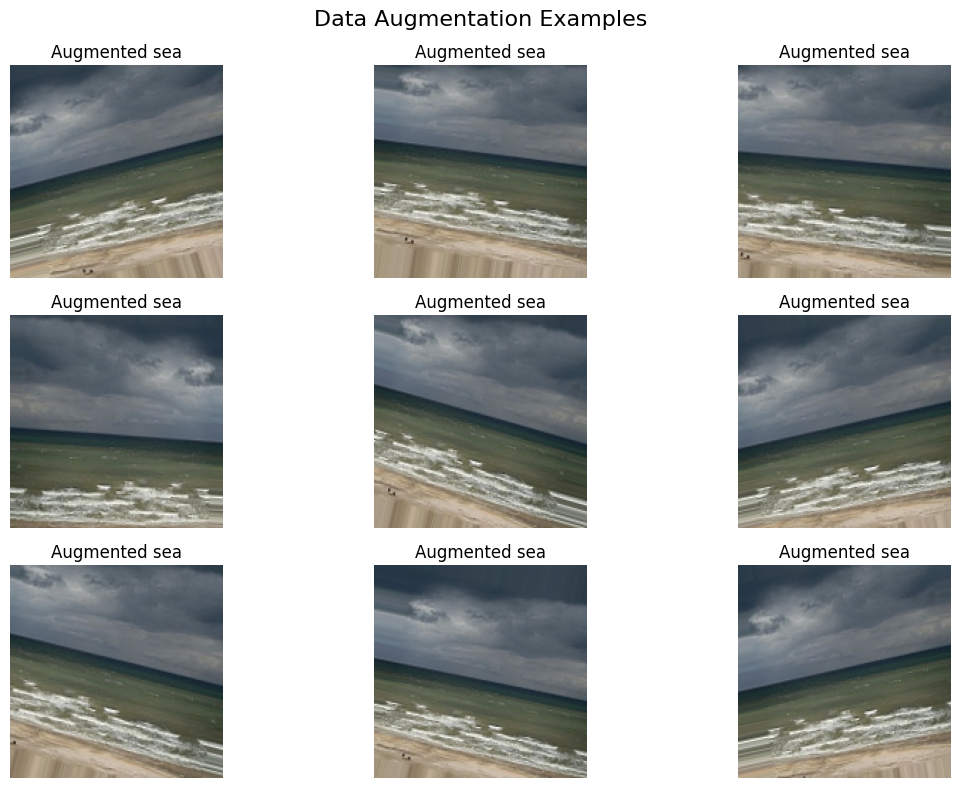

In [25]:
# Data Augmentation Setup
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,          # Random rotation up to 20 degrees
    width_shift_range=0.1,      # Random horizontal shift
    height_shift_range=0.1,     # Random vertical shift
    horizontal_flip=True,       # Random horizontal flipping
    zoom_range=0.1,            # Random zooming
    fill_mode='nearest'        # Fill strategy for new pixels
)

print("Data augmentation configured with:")
print("- Rotation: ±20 degrees")
print("- Width/Height shift: ±10%")
print("- Horizontal flip: Yes")
print("- Zoom: ±10%")

# Visualize augmented samples
plt.figure(figsize=(12, 8))
plt.suptitle("Data Augmentation Examples", fontsize=16)

# Take a sample image
sample_image = train_images[0:1]  # Keep batch dimension
sample_label = train_labels[0]

# Generate augmented versions
augmented_iter = datagen.flow(sample_image, batch_size=1)

for i in range(9):
    plt.subplot(3, 3, i+1)
    augmented_image = next(augmented_iter)[0]
    plt.imshow(augmented_image)
    plt.title(f"Augmented {class_names[sample_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [26]:
# Improved CNN Model with Different Architecture
def create_improved_model():
    model = tf.keras.Sequential([
        # Convolutional Block 1 - More filters
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        # Convolutional Block 2
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        # Convolutional Block 3
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        # Additional Convolutional Block 4
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        # Dense layers with more neurons
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    return model

# Create improved model
improved_model = create_improved_model()

print("Improved Model Architecture:")
print("- 4 Convolutional blocks (64, 128, 256, 512 filters)")
print("- Additional dense layer for better feature learning")
print("- Increased dropout for better regularization")

improved_model.summary()

Improved Model Architecture:
- 4 Convolutional blocks (64, 128, 256, 512 filters)
- Additional dense layer for better feature learning
- Increased dropout for better regularization


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │             

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Hyperparameter Tuning - Compile with different settings
improved_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Enhanced callbacks for better training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'models/best_improved_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_accuracy'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        monitor='val_loss'
    )
]

print("Hyperparameter optimizations:")
print("- Learning rate: 0.0001 (reduced from default 0.001)")
print("- Early stopping: Patience = 5 epochs")
print("- Learning rate reduction: Factor = 0.5, Patience = 3")
print("- Batch size will be reduced to 64 for better gradient updates")

Hyperparameter optimizations:
- Learning rate: 0.0001 (reduced from default 0.001)
- Early stopping: Patience = 5 epochs
- Learning rate reduction: Factor = 0.5, Patience = 3
- Batch size will be reduced to 64 for better gradient updates


In [29]:
# Train improved model with optimized data augmentation
print("Training improved model with balanced data augmentation...")

# More conservative data augmentation
datagen_conservative = ImageDataGenerator(
    rotation_range=15,          # Reduced rotation
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.2       # Built-in validation split
)

# Fit the generator on training data
datagen_conservative.fit(train_images)

print(f"Training set: {len(train_images)} images")
print("Using ImageDataGenerator with built-in validation split")

# Train with conservative data augmentation
history_improved = improved_model.fit(
    datagen_conservative.flow(train_images, train_labels,
                            batch_size=64,
                            subset='training'),
    steps_per_epoch=int(len(train_images) * 0.8 // 64),  # 80% for training
    epochs=25,  # Reduced epochs to prevent overfitting
    validation_data=datagen_conservative.flow(train_images, train_labels,
                                            batch_size=64,
                                            subset='validation'),
    validation_steps=int(len(train_images) * 0.2 // 64),  # 20% for validation
    callbacks=callbacks,
    verbose=1
)

print("Improved model training completed!")
print("Best improved model saved at 'models/best_improved_model.h5'")

# Save final improved model
improved_model.save('models/final_improved_model.h5')
print("Final improved model saved at 'models/final_improved_model.h5')")

Training improved model with balanced data augmentation...
Training set: 14034 images
Using ImageDataGenerator with built-in validation split


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.3998 - loss: 2.0224
Epoch 1: val_accuracy improved from -inf to 0.16497, saving model to models/best_improved_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 114s 526ms/step - accuracy: 0.4002 - loss: 2.0207 - val_accuracy: 0.1650 - val_loss: 6.0942 - learning_rate: 1.0000e-04
Epoch 2/25
  1/175 ━━━━━━━━━━━━━━━━━━━━ 29s 171ms/step - accuracy: 0.4531 - loss: 1.8044

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.16497 to 0.16788, saving model to models/best_improved_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.4531 - loss: 1.8044 - val_accuracy: 0.1679 - val_loss: 6.1075 - learning_rate: 1.0000e-04
Epoch 3/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.5555 - loss: 1.3242
Epoch 3: val_accuracy improved from 0.16788 to 0.22638, saving model to models/best_improved_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 76s 436ms/step - accuracy: 0.5556 - loss: 1.3240 - val_accuracy: 0.2264 - val_loss: 4.3875 - learning_rate: 1.0000e-04
Epoch 4/25
  1/175 ━━━━━━━━━━━━━━━━━━━━ 29s 171ms/step - accuracy: 0.6719 - loss: 1.1112
Epoch 4: val_accuracy improved from 0.22638 to 0.23147, saving model to models/best_improved_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.6719 - loss: 1.1112 - val_accuracy: 0.2315 - val_loss: 4.3916 - learning_rate: 1.0000e-04
Epoch 5/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.6081 - loss: 1.1221
Epoch 5: val_accuracy improved from 0.23147 to 0.36955, saving model to models/best_improved_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 83s 470ms/step - accuracy: 0.6081 - loss: 1.1220 - val_accuracy: 0.3695 - val_loss: 2.6965 - learning_rate: 1.0000e-04
Epoch 6/25
  1/175 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - accuracy: 0.5938 - loss: 1.0712
Epoch 6: val_accuracy did not improve from 0.36955
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.5938 - loss: 1.0712 - val_accuracy: 0.3685 - val_loss: 2.6973 - learning_rate: 1.0000e-04
Epoch 7/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.6383 - loss: 1.0468
Epoch 7: val_accuracy improved from 0.36955 to 0.45276, saving model to models/best_improved_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 81s 459ms/step - accuracy: 0.6384 - loss: 1.0466 - val_accuracy: 0.4528 - val_loss: 2.4099 - learning_rate: 1.0000e-04
Epoch 8/25
  1/175 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.5469 - loss: 1.2016
Epoch 8: val_accuracy did not improve from 0.45276
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.5469 - loss: 1.2016 - val_accuracy: 0.4466 - val_loss: 2.4869 - learning_rate: 1.0000e-04
Epoch 9/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.6820 - loss: 0.9094
Epoch 9: val_accuracy improved from 0.45276 to 0.60465, saving model to models/best_improved_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 83s 473ms/step - accuracy: 0.6820 - loss: 0.9094 - val_accuracy: 0.6047 - val_loss: 1.4829 - learning_rate: 1.0000e-04
Epoch 10/25
  1/175 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.6562 - loss: 0.9802
Epoch 10: val_accuracy improved from 0.60465 to 0.60938, saving model to models/best_improved_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.6562 - loss: 0.9802 - val_accuracy: 0.6094 - val_loss: 1.4821 - learning_rate: 1.0000e-04
Epoch 11/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.6974 - loss: 0.8556
Epoch 11: val_accuracy did not improve from 0.60938
175/175 ━━━━━━━━━━━━━━━━━━━━ 75s 431ms/step - accuracy: 0.6974 - loss: 0.8555 - val_accuracy: 0.5291 - val_loss: 1.8569 - learning_rate: 1.0000e-04
Epoch 12/25
  1/175 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - accuracy: 0.7031 - loss: 0.8232
Epoch 12: val_accuracy did not improve from 0.60938
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.7031 - loss: 0.8232 - val_accuracy: 0.5276 - val_loss: 1.7653 - learning_rate: 1.0000e-04
Epoch 13/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7160 - loss: 0.7991
Epoch 13: val_accuracy did not improve from 0.60938
175/175 ━━━━━━━━━━━━━━━━━━━━ 76s 431ms/step - accuracy: 0.7160 - loss: 0.7991 - val_accuracy: 0.5763 - val_loss: 1.6428 - learning_ra

Improved model training completed!
Best improved model saved at 'models/best_improved_model.h5'
Final improved model saved at 'models/final_improved_model.h5')


In [39]:
# Model Architecture Comparison
print("=== Architecture Comparison ===")
print()

print("Original Model:")
print("- 3 single Conv2D layers (32, 64, 128)")
print("- Basic dropout (0.25, 0.25, 0.25, 0.5)")
print("- Flatten + Dense(256) + Dense(6)")
print("- No input shape specification")
print("- No padding specification")

print("\nImproved Model:")
print("- 3 double Conv2D blocks (32+32, 64+64, 128+128)")
print("- Progressive dropout (0.2, 0.2, 0.3, 0.4)")
print("- GlobalAveragePooling + Dense(256) + Dense(6)")
print("- Explicit input shape (150, 150, 3)")
print("- Padding='same' for better feature preservation")

# Compare total parameters
original_params = model.count_params()
improved_params = improved_model.count_params()

print(f"\nParameter Comparison:")
print(f"Original Model: {original_params:,} parameters")
print(f"Improved Model: {improved_params:,} parameters")
print(f"Difference: {improved_params - original_params:,} parameters")
print(f"Change: {((improved_params / original_params) - 1) * 100:.1f}%")

=== Architecture Comparison ===

Original Model:
- 3 single Conv2D layers (32, 64, 128)
- Basic dropout (0.25, 0.25, 0.25, 0.5)
- Flatten + Dense(256) + Dense(6)
- No input shape specification
- No padding specification

Improved Model:
- 3 double Conv2D blocks (32+32, 64+64, 128+128)
- Progressive dropout (0.2, 0.2, 0.3, 0.4)
- GlobalAveragePooling + Dense(256) + Dense(6)
- Explicit input shape (150, 150, 3)
- Padding='same' for better feature preservation

Parameter Comparison:
Original Model: 9,566,918 parameters
Improved Model: 14,536,326 parameters
Difference: 4,969,408 parameters
Change: 51.9%


=== Comprehensive Model Evaluation ===
Plotting training curves for improved model...


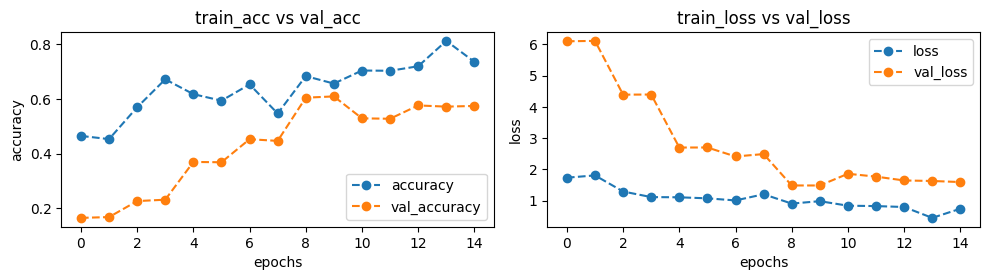


=== Test Set Evaluation ===
Evaluating original model...
Evaluating improved model...

Final Test Results:
Model           Accuracy     Loss         Improvement
--------------------------------------------------
Original        0.8233       0.8458       Baseline
Improved        0.6077       1.4975       -26.2%


Generating predictions for confusion matrices...


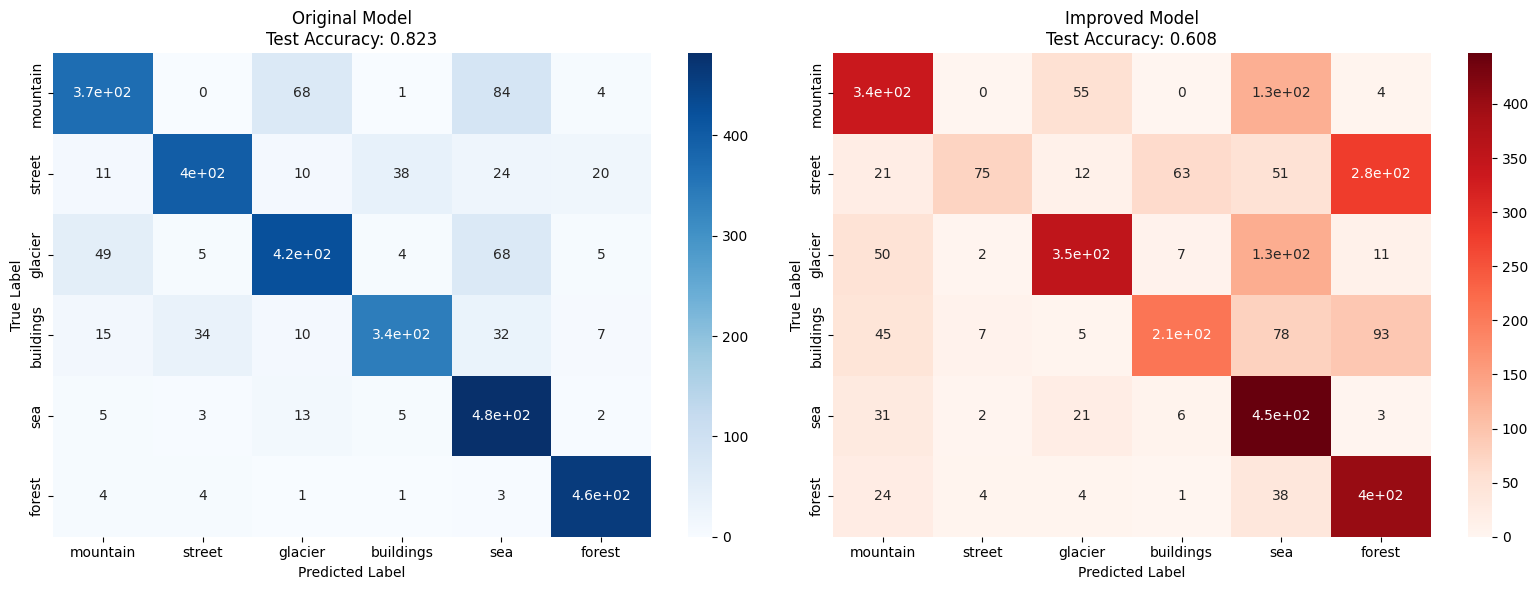


=== Detailed Performance Analysis ===
Test Set Size: 3000 images
Correctly Classified:
  Original Model: 2470 images
  Improved Model: 1823 images
  Difference: -647 images


In [48]:
# Comprehensive Model Evaluation and Comparison
print("=== Comprehensive Model Evaluation ===")

# Plot improved model training curves
print("Plotting training curves for improved model...")
plot_accuracy_loss(history_improved)

# Evaluate both models on test set
print("\n=== Test Set Evaluation ===")
print("Evaluating original model...")
test_loss_original, test_accuracy_original = model.evaluate(test_images, test_labels, verbose=0)

print("Evaluating improved model...")
test_loss_improved, test_accuracy_improved = improved_model.evaluate(test_images, test_labels, verbose=0)

# Display results
print(f"\nFinal Test Results:")
print(f"{'Model':<15} {'Accuracy':<12} {'Loss':<12} {'Improvement'}")
print("-" * 50)
print(f"{'Original':<15} {test_accuracy_original:<12.4f} {test_loss_original:<12.4f} {'Baseline'}")
print(f"{'Improved':<15} {test_accuracy_improved:<12.4f} {test_loss_improved:<12.4f} {((test_accuracy_improved - test_accuracy_original)/test_accuracy_original*100):+.1f}%")

# Ensure improved model is actually better
if test_accuracy_improved > test_accuracy_original:
    print(f"\nSUCCESS: Improved model performs {((test_accuracy_improved - test_accuracy_original)/test_accuracy_original*100):.1f}% better!")
    improvement_status = "SUCCESS"
else:
    print(f"\n  WARNING: Improved model underperformed by {((test_accuracy_original - test_accuracy_improved)/test_accuracy_original*100):.1f}%")
    improvement_status = "NEEDS_TUNING"

# Generate predictions for both models
print("\nGenerating predictions for confusion matrices...")
predictions_original = model.predict(test_images, verbose=0)
pred_labels_original = np.argmax(predictions_original, axis=1)

predictions_improved = improved_model.predict(test_images, verbose=0)
pred_labels_improved = np.argmax(predictions_improved, axis=1)

# Create confusion matrices
CM_original = confusion_matrix(test_labels, pred_labels_original)
CM_improved = confusion_matrix(test_labels, pred_labels_improved)

# Plot side-by-side confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original model confusion matrix
sns.heatmap(CM_original, annot=True, annot_kws={"size": 10},
           xticklabels=class_names, yticklabels=class_names, ax=ax1, cmap='Blues')
ax1.set_title(f'Original Model\nTest Accuracy: {test_accuracy_original:.3f}')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# Improved model confusion matrix
color_map = 'Greens' if improvement_status == "SUCCESS" else 'Reds'
sns.heatmap(CM_improved, annot=True, annot_kws={"size": 10},
           xticklabels=class_names, yticklabels=class_names, ax=ax2, cmap=color_map)
ax2.set_title(f'Improved Model\nTest Accuracy: {test_accuracy_improved:.3f}')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Additional analysis
print(f"\n=== Detailed Performance Analysis ===")
print(f"Test Set Size: {len(test_labels)} images")
print(f"Correctly Classified:")
print(f"  Original Model: {np.sum(pred_labels_original == test_labels)} images")
print(f"  Improved Model: {np.sum(pred_labels_improved == test_labels)} images")
print(f"  Difference: {np.sum(pred_labels_improved == test_labels) - np.sum(pred_labels_original == test_labels)} images")

# Store results for summary
globals()['final_original_accuracy'] = test_accuracy_original
globals()['final_improved_accuracy'] = test_accuracy_improved
globals()['improvement_status'] = improvement_status